In [1]:
import numpy as np
import pandas as pd

In [2]:
# define default coefficients
v= 0.25    # drift term
lbg=0.1    # Specific algal maintenance respiration losses
mumax=1.2  # Maximum specific algal production rate
rhomax=0.2 # Maximum specific algal nutrient uptake rate
qmax=0.04  # Maximum algal nutrient quota
qmin=0.004 # Minimum algal nutrient quota 
m=1.5      # Half-saturation constant of algal nutrient uptake
h=120.0    # Half-saturation constant of light-dependent algal production
I0 = 300   # Light intensity at the surface 
kbg=0.4    # Background light-attenuation coefficient - change to 0.02 to see some oscillations? Originally 0.4
r = 0.02   # Specific mineralization rate of sedimented nutrients

def rnorm(mu,sigma,z):
    """create normal hump around mu over z, of std. dev. sigma"""
    return np.exp( -(z-mu)**2/(2*sigma**2) )/ np.sqrt(2*np.pi*sigma**2)

def I(z,A,I_0=I0,k = 0.0003):
    """Function to plot I using array A[:,i], default k=0.0003, larger values of k make effect of A on I more apparent"""
    integral = np.zeros(len(z))
    integral[1:] = np.cumsum(k*A[1:]) 
    return I_0 * np.exp( - integral- kbg*z)

def p(I,q):
    return mumax * (1.0 - qmin/q) * (I/(h + I))

def rho(q, Rd):
    return rhomax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

# Single Light Shift

In [3]:
def next_step(z,A, Rb, Rd, Rs,dz,dt,d,I_0=I0):
    """Calculates next step for input arrays of length zmax"""
    
    II = I(z,A,I_0=I_0)
    q = Rb[1:-1]/A[1:-1]
    pp = p(II[1:-1],q)
    rrho = rho(q,Rd[1:-1])
    
    A_next = np.zeros(len(A))
    Rb_next = np.zeros(len(Rb))
    Rd_next = np.zeros(len(Rd))
    
    A_drift = v * (A[2:]-A[:-2]) / (2*dz)
    A_diffusion = d * (A[2:]-2*A[1:-1] + A[:-2]) / (dz**2)
    Rb_drift = v * (Rb[2:]-Rb[:-2]) / (2*dz)
    Rb_diffusion = d * (Rb[2:]-2*Rb[1:-1] + Rb[:-2]) / (dz**2)
    Rd_diffusion = d * (Rd[2:]-2*Rd[1:-1] + Rd[:-2]) / (dz**2)
    
    A_next[1:-1] = A[1:-1] + dt * ( pp*A[1:-1] -lbg*A[1:-1] - A_drift + A_diffusion )
    A_next[0] = 4*d/(2*v*dz + 3*d)*A_next[1] - d/(2*v*dz + 3*d)*A_next[2] 
    A_next[-1] = (4*A_next[-2] - A_next[-3])/3
    
    Rb_next[1:-1] = Rb[1:-1] + dt * (rrho*A[1:-1] -lbg*Rb[1:-1] - Rb_drift + Rb_diffusion )
    Rb_next[0] = 4*d/(2*v*dz + 3*d)*Rb_next[1] - d/(2*v*dz + 3*d)*Rb_next[2] 
    Rb_next[-1] = (4*Rb_next[-2] - Rb_next[-3])/3
    
    Rs_next = Rs + dt*(v*Rb[-1] - r*Rs)
    
    Rd_next[1:-1] = Rd[1:-1] + dt*(lbg*Rb[1:-1] -rrho*A[1:-1] + Rd_diffusion)
    Rd_next[0] = (4*Rd_next[1] - Rd_next[2])/3 
    Rd_next[-1] = (2*r*dz*Rs_next + 4*d*Rd_next[-2] - d*Rd_next[-3])/(3*d)
    
    
    return A_next, Rb_next, Rd_next, Rs_next
    


In [5]:
def get_light_shift(zmax=30.0, tmax=100.0, d=1.0, I0=300.0, light_shift=0.6, light_change=0.5):
    """ A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt = get_light_shift(zmax=30.0, tmax=100.0, d=1.0, I0=300.0, light_shift=0.6) 
    light_shift such that shift occurs at light_shift*tmax"""
    
    dz = 0.1 ## change to 0.02 or ok?
    dt = dz/1000 # temporary 
    Nz = int(zmax/dz)
    Nt = int(tmax/ (1000*dt) )

    z_grid = np.arange(0,zmax,dz)
    time_steps = np.arange(0,tmax,dt)
    
    shift_loc = int(0.6*len(time_steps))

    A_0 = 100 
    Rb_0 = 2.2
    Rd_0 = 30 
    Rs_0 = 0
    
    A = np.zeros((Nz,Nt)) # RESULTS MATRIX: rows: deeper z-values, cols: time steps forward
    A[:,0] = A_0 * np.ones(Nz) # creates homogenous initial conditions
    Rb = np.zeros((Nz,Nt))
    Rb[:,0] = Rb_0 * np.ones(Nz)
    Rd = np.zeros((Nz,Nt))
    Rd[:,0] = Rd_0 * np.ones(Nz)
    Rs = np.zeros(Nt)
    A_next,Rb_next,Rd_next, Rs_next = A[:,0], Rb[:,0], Rd[:,0], Rs[0] #initial conditions

    i = 1
    counter = 1
    for t in time_steps[:shift_loc]:
        
        A_next, Rb_next, Rd_next, Rs_next = next_step(z_grid, A_next, Rb_next, Rd_next, Rs_next, dz,dt,d)
        
        if ( i % 1000 == 0):
            A[:,counter],Rb[:,counter],Rd[:,counter],Rs[counter] = A_next,Rb_next,Rd_next,Rs_next
            counter = counter +1
            
        i = i+1
      
    I0_new = I0*light_change
    for t in time_steps[shift_loc:-1]:
        A_next, Rb_next, Rd_next, Rs_next = next_step(z_grid, A_next, Rb_next, Rd_next, Rs_next, dz,dt,d,I_0=I0_new)
        
        if ( i % 1000 == 0):
            A[:,counter],Rb[:,counter],Rd[:,counter],Rs[counter] = A_next,Rb_next,Rd_next,Rs_next
            counter = counter +1
            
        i = i+1
        
    return A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt
    

In [7]:
A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt = get_light_shift(zmax=30.0, tmax=100.0, d=1.0, I0=300.0, light_shift=0.6)

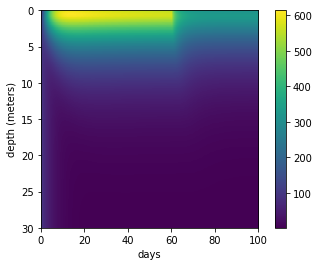

In [15]:
tmax = 100
zmax = 30
import matplotlib.pyplot as plt
# Heatmap
plt.imshow(A[:,:],aspect=tmax/zmax,origin="lower",extent=(0,tmax,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.colorbar()

In [10]:
A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt = get_light_shift(zmax=30.0, tmax=200.0, d=1.0, I0=300.0, light_shift=0.6)

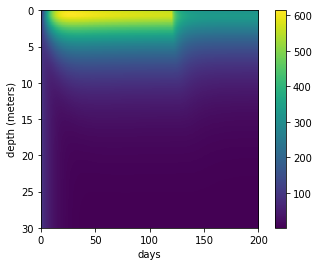

In [11]:
tmax = 200
zmax = 30
import matplotlib.pyplot as plt
# Heatmap
plt.imshow(A[:,:],aspect=tmax/zmax,origin="lower",extent=(0,tmax,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.colorbar()

# "Volcano"/Shock Scenario
Light disappears for 1/5/10/100 days, does population return to previous stationary distribution? How long does it take? Does this differ for different lengths of time without light?

    dt=dz/1000
    every (1/dt) steps = 1 day

In [3]:
import my_equations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [4]:
def get_light_shock(zmax=10.0, tmax=500.0, d=1.0, I0=300.0, dz=0.1, dt_ratio = 1/1000, light_shift_time=0.5, light_shift_duration=1, light_change=0.5):
    """ A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt = get_light_shift(zmax=30.0, tmax=100.0, d=1.0, I0=300.0, light_shift=0.6)
    
    Simulates a light shift on day light_shift*tmax which lasts for light_shift_duration days and changes the light intensity by a factor of
    
    light_change."""
    
    I0_new = I0*light_change
    
    dt = dz*dt_ratio
    Nz = int(zmax/dz)
    Nt = int(tmax/ (1000*dt) )

    z_grid = np.arange(0,zmax,dz)
    time_steps = np.arange(0,tmax,dt)
    
    shift_duration = int(light_shift_duration / dt)     #every (1/dt) steps = 1 day
    shift_loc_start = int(light_shift_time*len(time_steps))
    shift_loc_end = int(shift_loc_start + shift_duration)

    A_0 = 100 
    Rb_0 = 2.2
    Rd_0 = 30 
    Rs_0 = 0
    
    # RESULTS MATRIX: rows: deeper z-values, cols: time steps forward
    A = np.zeros((Nz,Nt))
    Rb = np.zeros((Nz,Nt))
    Rd = np.zeros((Nz,Nt))
    Rs = np.zeros(Nt)
    
    # creates homogenous initial conditions
    A[:,0] = A_0 * np.ones(Nz) 
    Rb[:,0] = Rb_0 * np.ones(Nz)
    Rd[:,0] = Rd_0 * np.ones(Nz)
    
    A_next,Rb_next,Rd_next, Rs_next = A[:,0], Rb[:,0], Rd[:,0], Rs[0] #initial conditions

    i = 1
    counter = 1
    for t in time_steps[:shift_loc_start]:
        A_next, Rb_next, Rd_next, Rs_next = my_equations.next_step(z_grid, A_next, Rb_next, Rd_next, Rs_next, dz,dt,d, I_0=I0)
        if ( i % 1000 == 0):
            A[:,counter],Rb[:,counter],Rd[:,counter],Rs[counter] = A_next,Rb_next,Rd_next,Rs_next
            counter = counter +1
        i += 1
      
    for t in time_steps[shift_loc_start:shift_loc_end]:
        A_next, Rb_next, Rd_next, Rs_next = my_equations.next_step(z_grid, A_next, Rb_next, Rd_next, Rs_next, dz,dt,d,I_0=I0_new)
        if ( i % 1000 == 0):
            A[:,counter],Rb[:,counter],Rd[:,counter],Rs[counter] = A_next,Rb_next,Rd_next,Rs_next
            counter = counter +1
        i += 1
        
    I0_new = I0*light_change
    for t in time_steps[shift_loc_end:-1]:
        A_next, Rb_next, Rd_next, Rs_next = my_equations.next_step(z_grid, A_next, Rb_next, Rd_next, Rs_next, dz, dt, d, I_0=I0)
        if ( i % 1000 == 0):
            A[:,counter],Rb[:,counter],Rd[:,counter],Rs[counter] = A_next,Rb_next,Rd_next,Rs_next
            counter = counter +1
        i += 1
        
    return A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt
    

In [20]:
tmax=1000.0
d=1.0
zmax=20.0
dt_ratio = 1/1000
shift_start=0.5
dz=0.1
A, Rb, Rd, Rs, z_grid, time_steps, Nz, Nt = get_light_shock(zmax=zmax, tmax=tmax, d=d, I0=300.0, dz=dz, dt_ratio = dt_ratio, light_shift_time=shift_start, light_shift_duration=100, light_change=0)

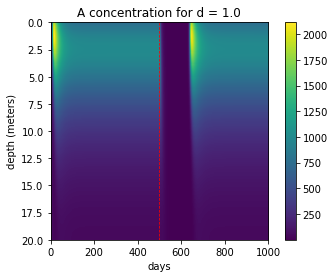

In [21]:
# Heatmap
plt.imshow(A[:,:],aspect=tmax/zmax,origin="lower",extent=(0,tmax,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.axvline(x=tmax*shift_start, color='red',linestyle='--',linewidth=0.75)
plt.title("A concentration for d = {}".format(d))
plt.colorbar()

In [8]:
help(my_equations.get_rho)

Help on function get_rho in module my_equations:

get_rho(Rb, A, Rd)
    Get specific algal uptake ("feeding") rate



In [22]:
rho = my_equations.get_rho(Rb,A,Rd)

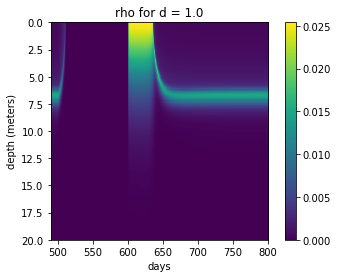

In [38]:
start = 490
end = 800
plt.imshow(rho[:,int(start/dz):int(end/dz)],aspect=(end-start)/zmax,origin="lower",extent=(start,end,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("rho for d = {}".format(d))
plt.colorbar()

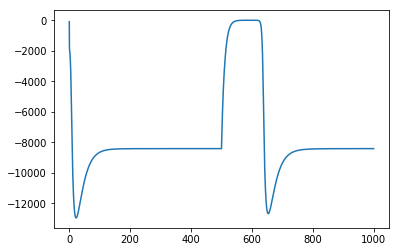

In [61]:
tmesh = np.linspace(0,tmax,rho.shape[1])
plt.plot(tmesh,growth.sum(axis=0))

(200,)

In [ ]:
plot()

In [60]:
growth = (rho-lbg)*A

In [44]:
growth

array([[-0.0047619 , -0.03658075, -0.0538981 , ..., -0.09944567,
        -0.09944567, -0.09944567],
       [-0.0047619 , -0.03659513, -0.05391929, ..., -0.09944531,
        -0.09944531, -0.09944531],
       [-0.0047619 , -0.03663724, -0.05398119, ..., -0.09944425,
        -0.09944425, -0.09944425],
       ...,
       [-0.0047619 , -0.04394018, -0.06696575, ..., -0.0999963 ,
        -0.0999963 , -0.0999963 ],
       [-0.0047619 , -0.04394029, -0.06696593, ..., -0.09999635,
        -0.09999635, -0.09999635],
       [-0.0047619 , -0.04394032, -0.06696598, ..., -0.09999637,
        -0.09999637, -0.09999637]])

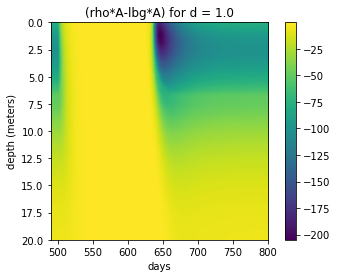

In [40]:
start = 490
end = 800
plt.imshow(growth[:,int(start/dz):int(end/dz)],aspect=(end-start)/zmax,origin="lower",extent=(start,end,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("(rho*A-lbg*A) for d = {}".format(d))
plt.colorbar()

<IPython.core.display.Javascript object>


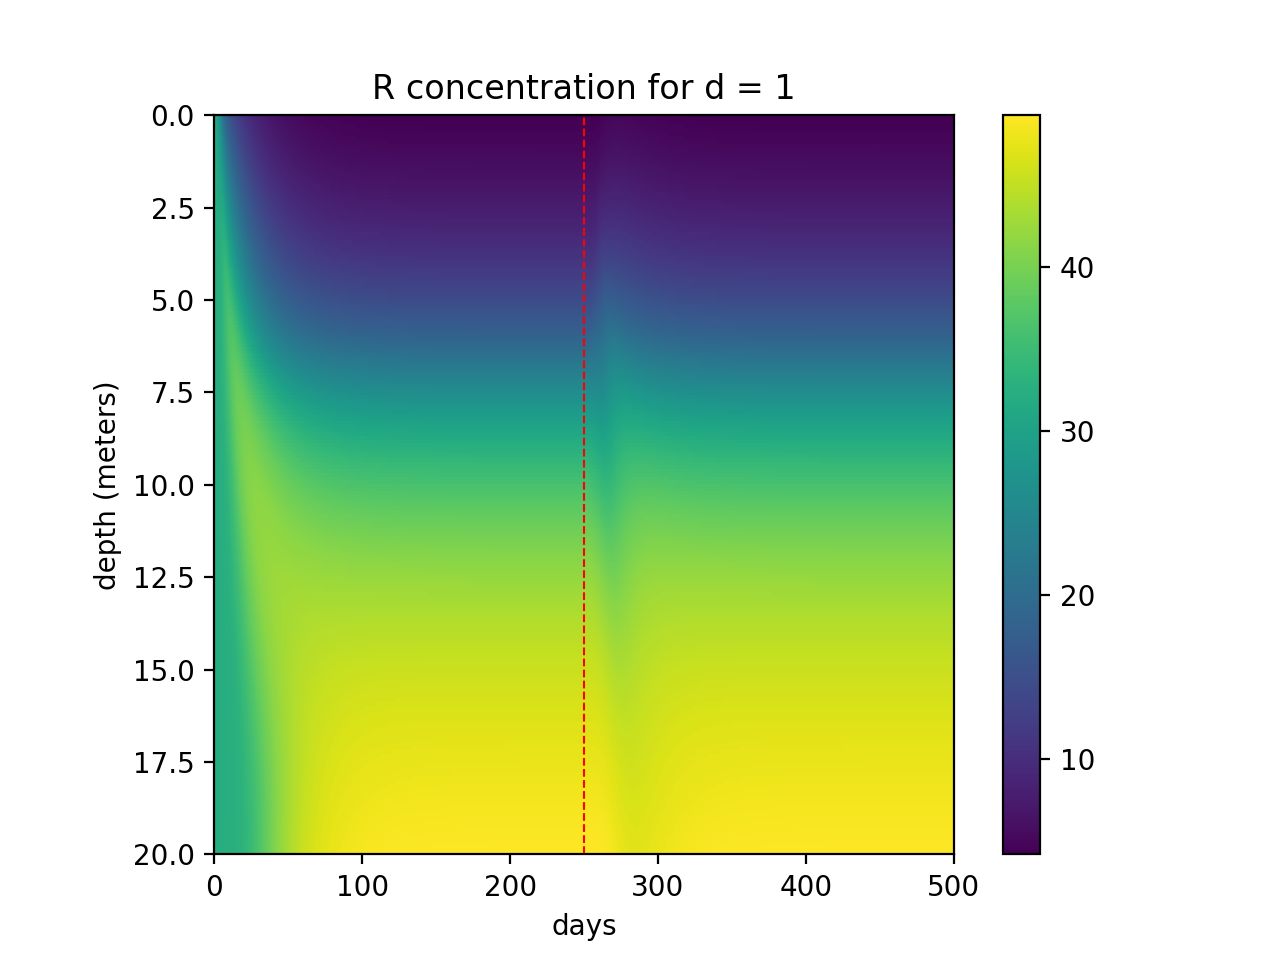

In [147]:
R = my_equations.get_R(Rd,Rb)
# Heatmap
plt.imshow(R[:,:],aspect=tmax/zmax,origin="lower",extent=(0,tmax,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("R concentration for d = {}".format(d))
plt.axvline(x=tmax*shift_start, color='red',linestyle='--',linewidth=0.75)
plt.colorbar()

<IPython.core.display.Javascript object>


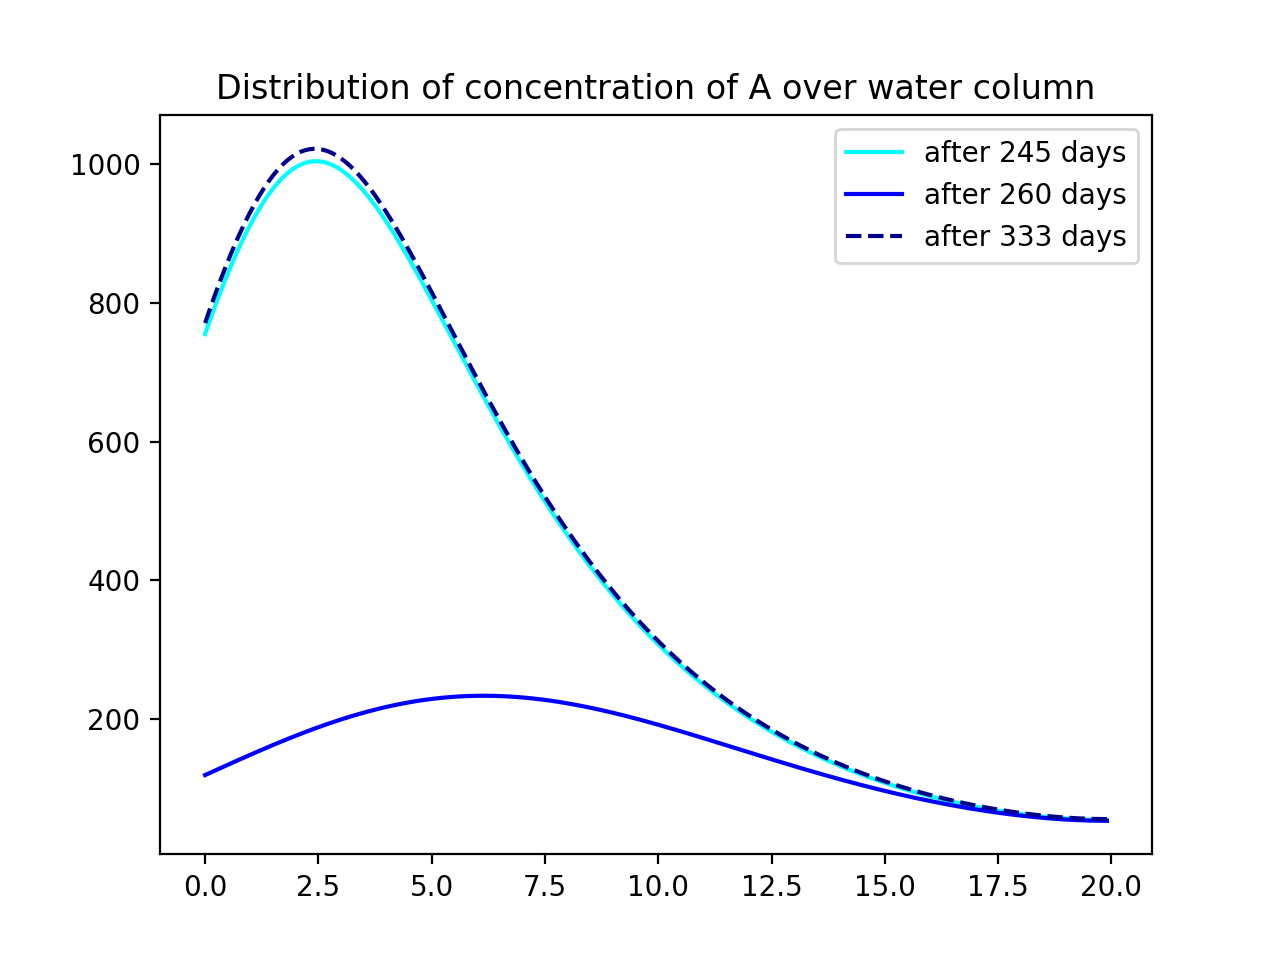

Text(0.5, 1.0, 'Distribution of concentration of A over water column')

In [148]:
%matplotlib notebook
# Visualize Shift
first = 245
second = 260
third = 333
plt.plot(z_grid,A[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,A[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,A[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of A over water column')

<IPython.core.display.Javascript object>


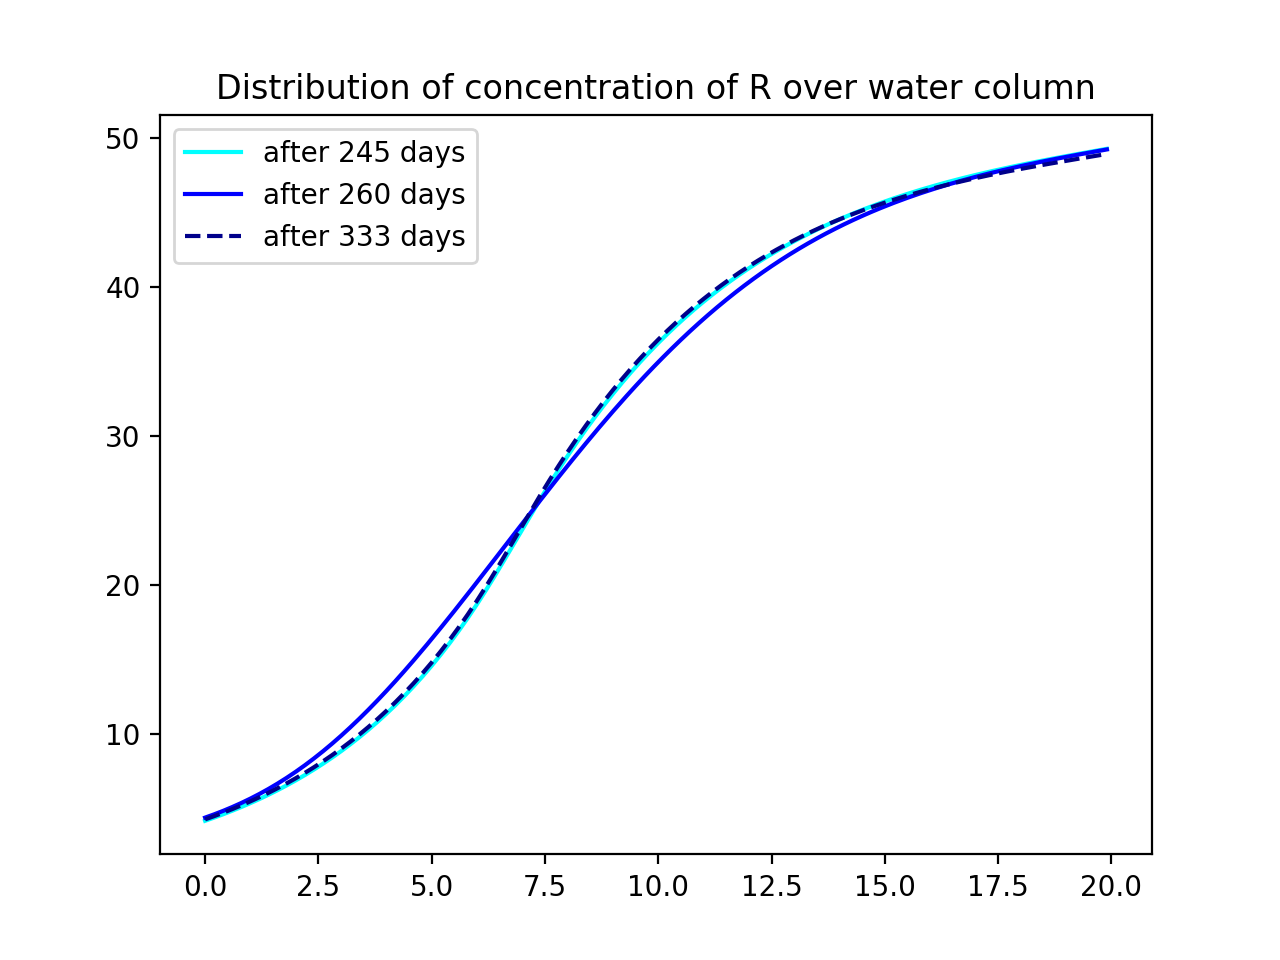

Text(0.5, 1.0, 'Distribution of concentration of R over water column')

In [149]:
# Visualize Shift
first = 245
second = 260
third = 333
plt.plot(z_grid,R[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,R[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,R[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of R over water column')

# Heatmap showing initial evolution of system

<IPython.core.display.Javascript object>


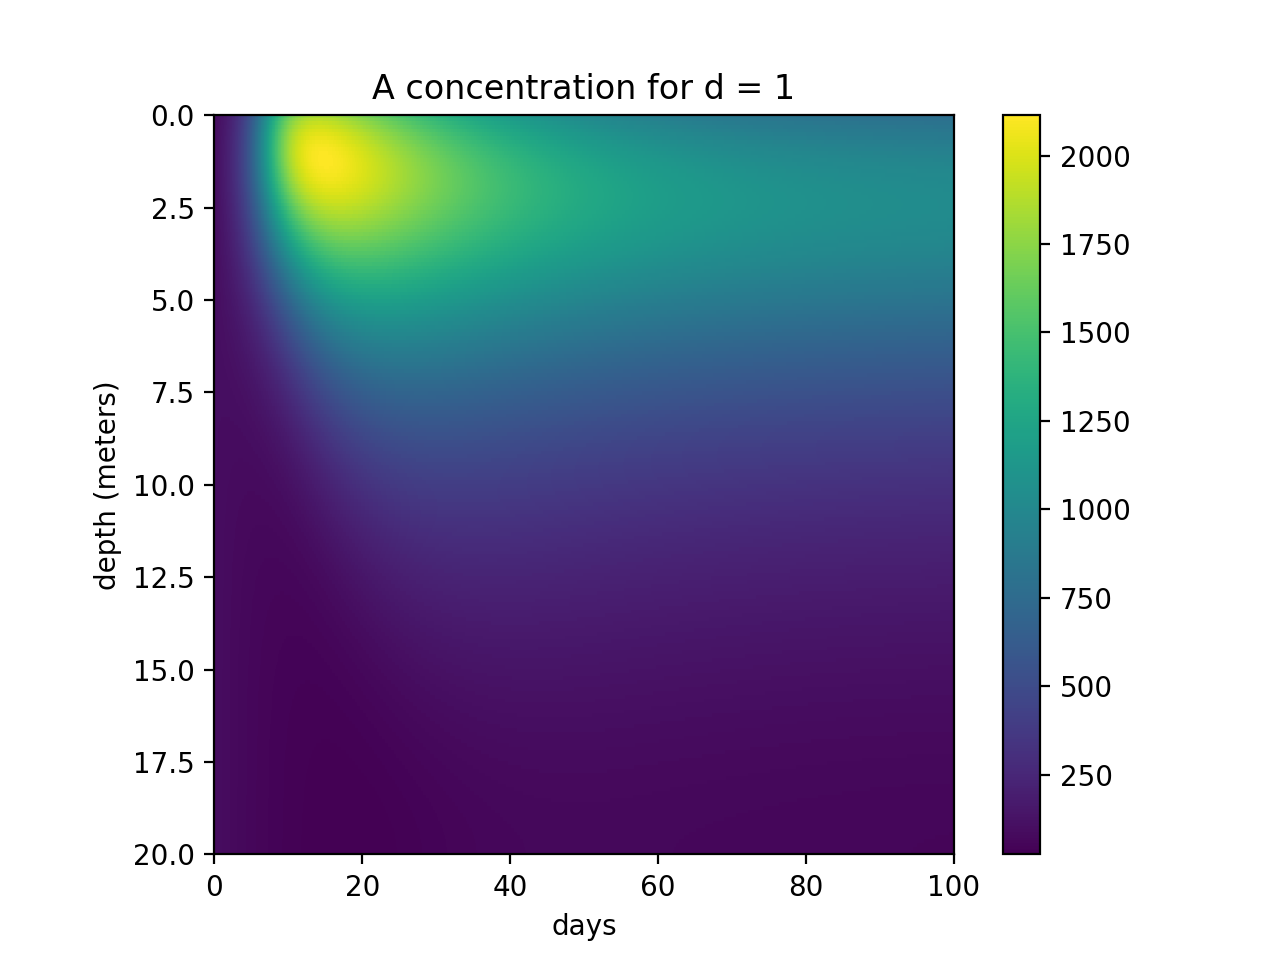

In [38]:
end = 100
plt.imshow(A[:,:int(end/dz)],aspect=end/zmax,origin="lower",extent=(0,end,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("A concentration for d = {}".format(d))
plt.colorbar()

<IPython.core.display.Javascript object>


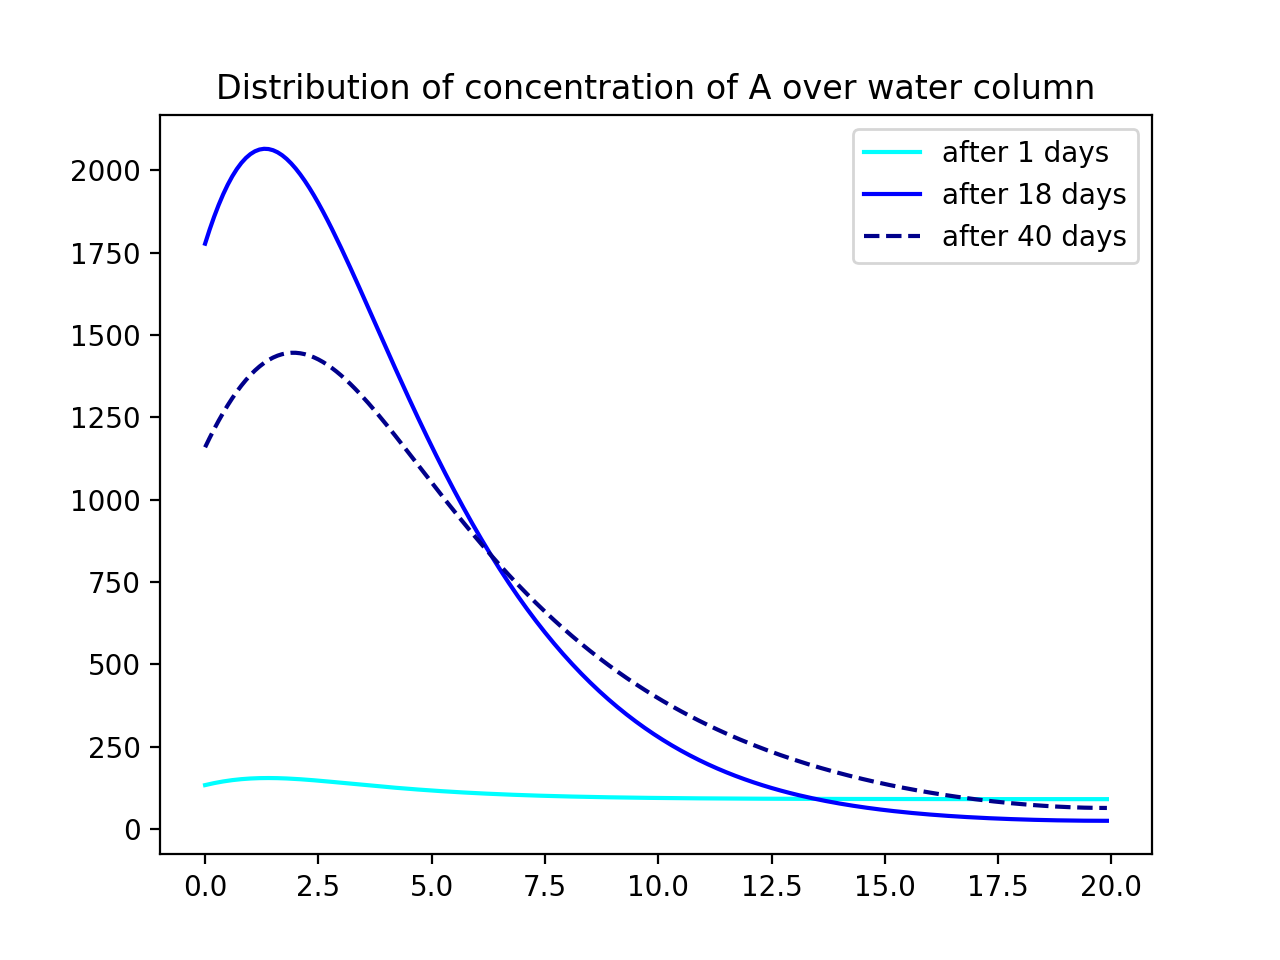

Text(0.5, 1.0, 'Distribution of concentration of A over water column')

In [74]:
# Visualize Shift
first = 1
second = 18
third = 40
plt.plot(z_grid,A[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,A[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,A[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of A over water column')

<IPython.core.display.Javascript object>


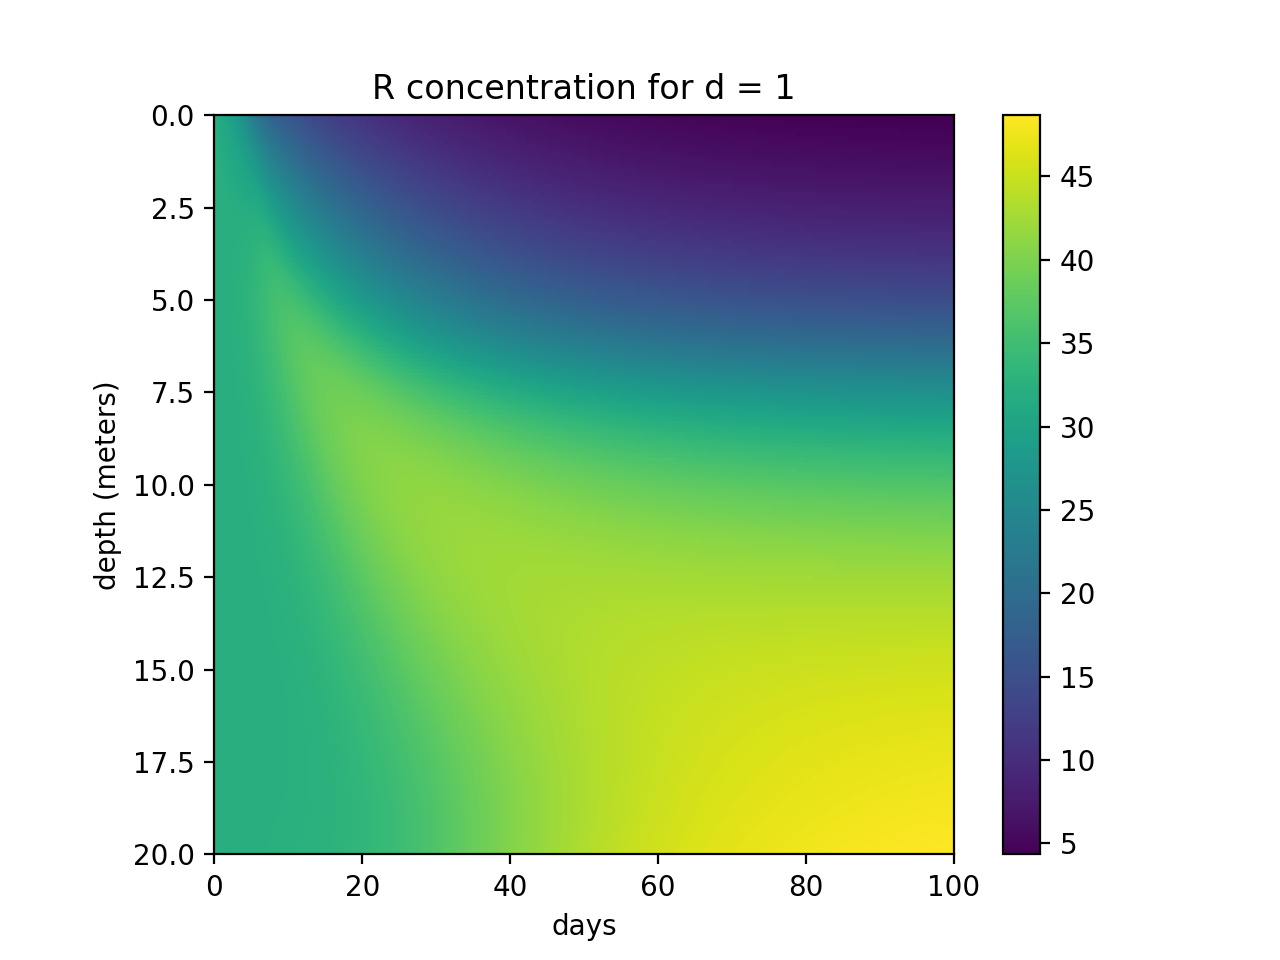

In [67]:
end = 100
plt.imshow(R[:,:int(end/dz)],aspect=end/zmax,origin="lower",extent=(0,end,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("R concentration for d = {}".format(d))
plt.colorbar()

<IPython.core.display.Javascript object>


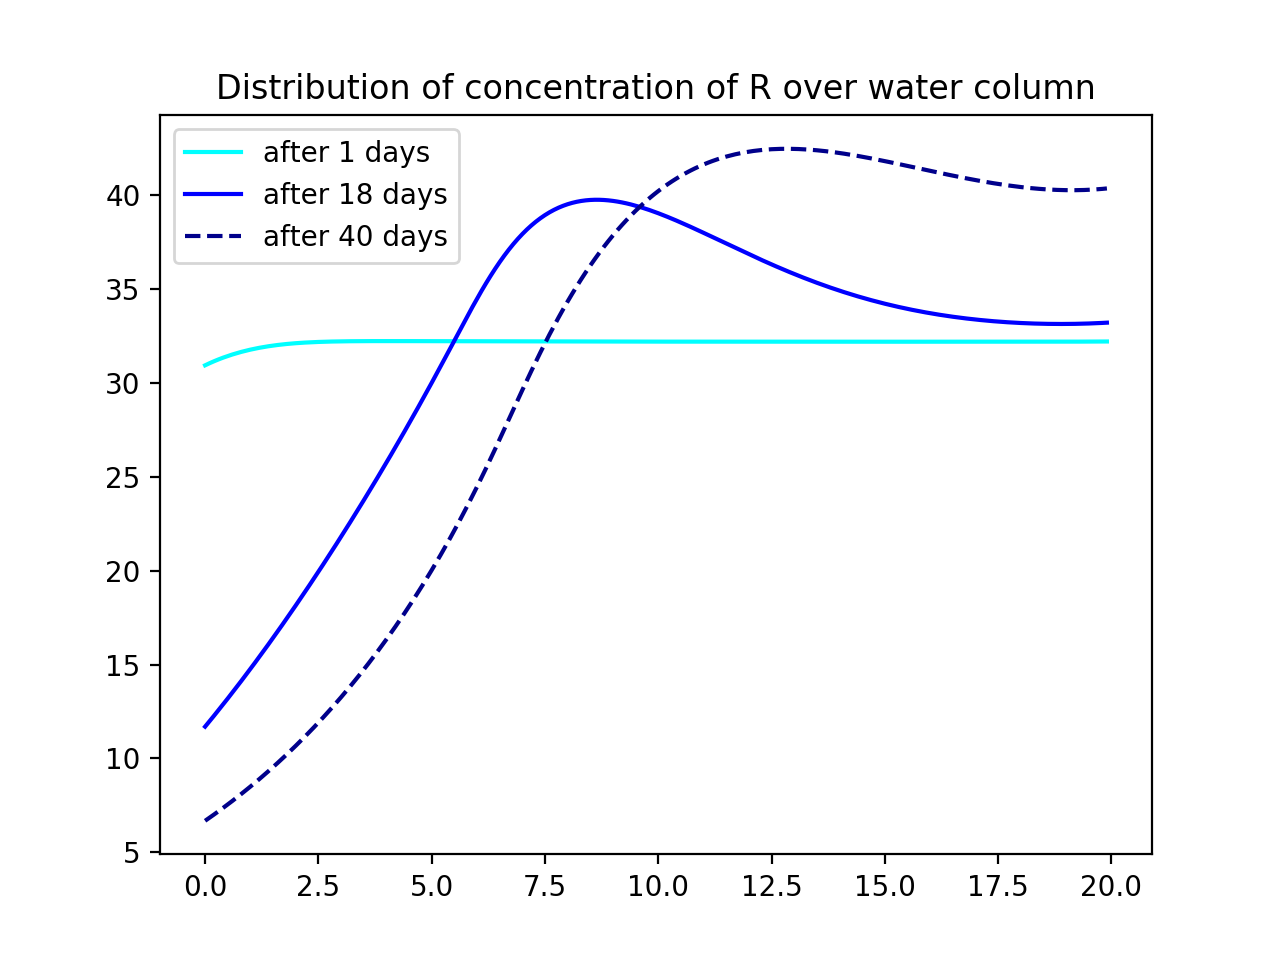

Text(0.5, 1.0, 'Distribution of concentration of R over water column')

In [73]:
# Visualize Shift
first = 1
second = 18
third = 40
plt.plot(z_grid,R[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,R[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,R[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of R over water column')

# Heatmaps showing when light disappears

<IPython.core.display.Javascript object>


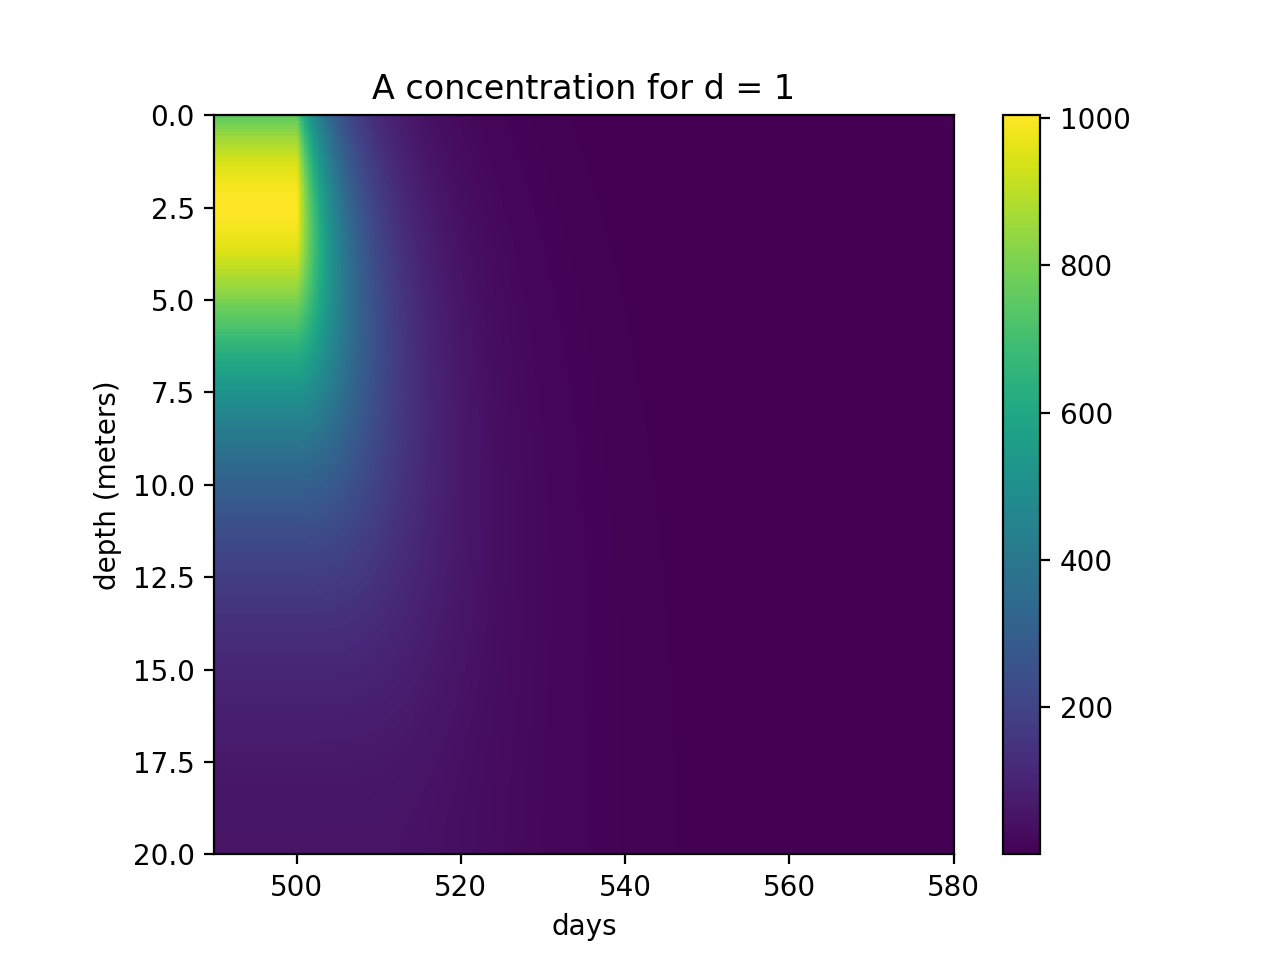

In [49]:
start = 490
end = 580
plt.imshow(A[:,int(start/dz):int(end/dz)],aspect=(end-start)/zmax,origin="lower",extent=(start,end,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("A concentration for d = {}".format(d))
plt.colorbar()

<IPython.core.display.Javascript object>


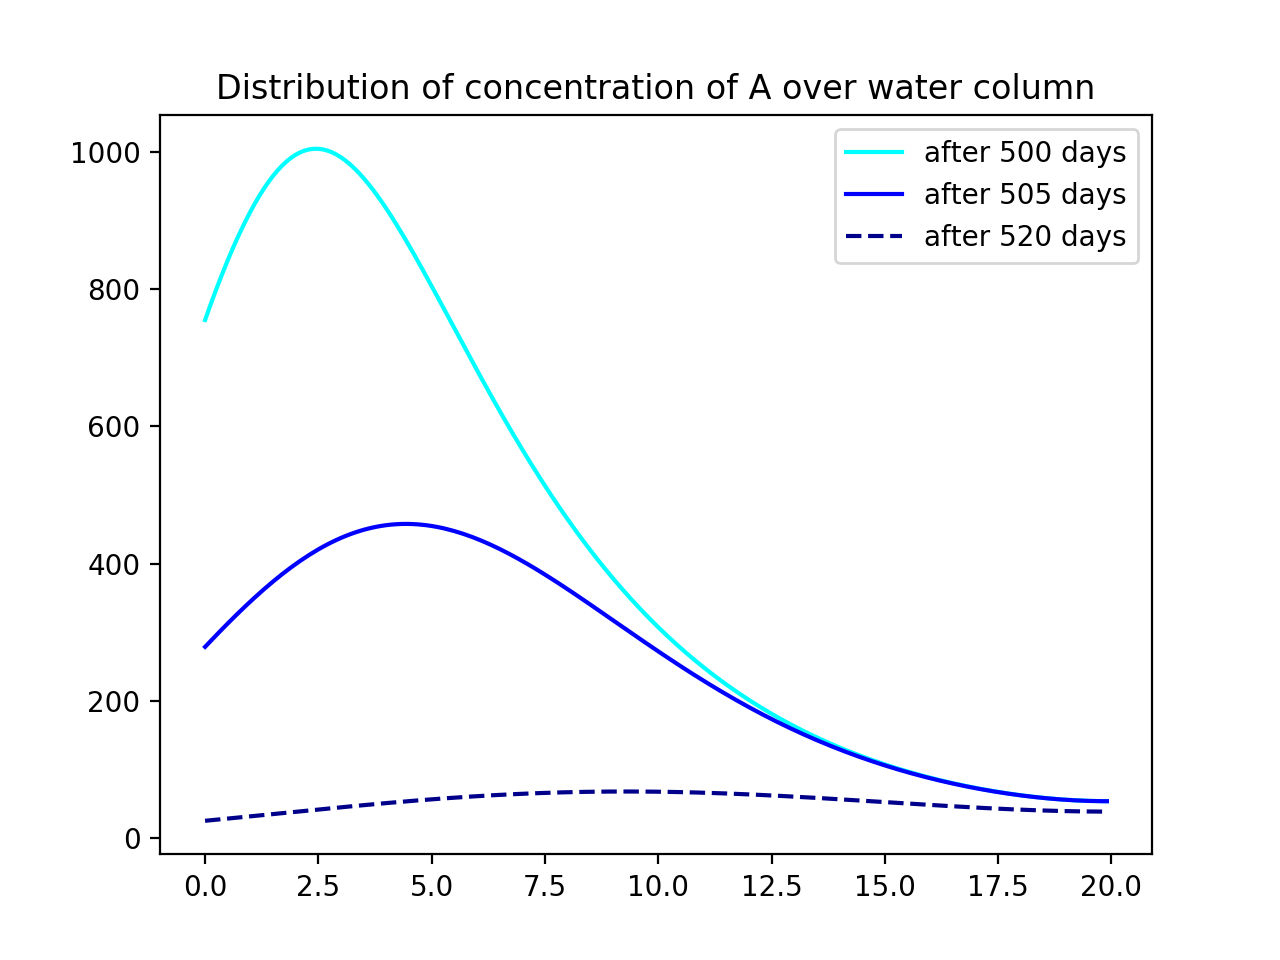

Text(0.5, 1.0, 'Distribution of concentration of A over water column')

In [75]:
# Visualize Shift
first = 500
second = 505
third = 520
plt.plot(z_grid,A[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,A[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,A[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of A over water column')

<IPython.core.display.Javascript object>


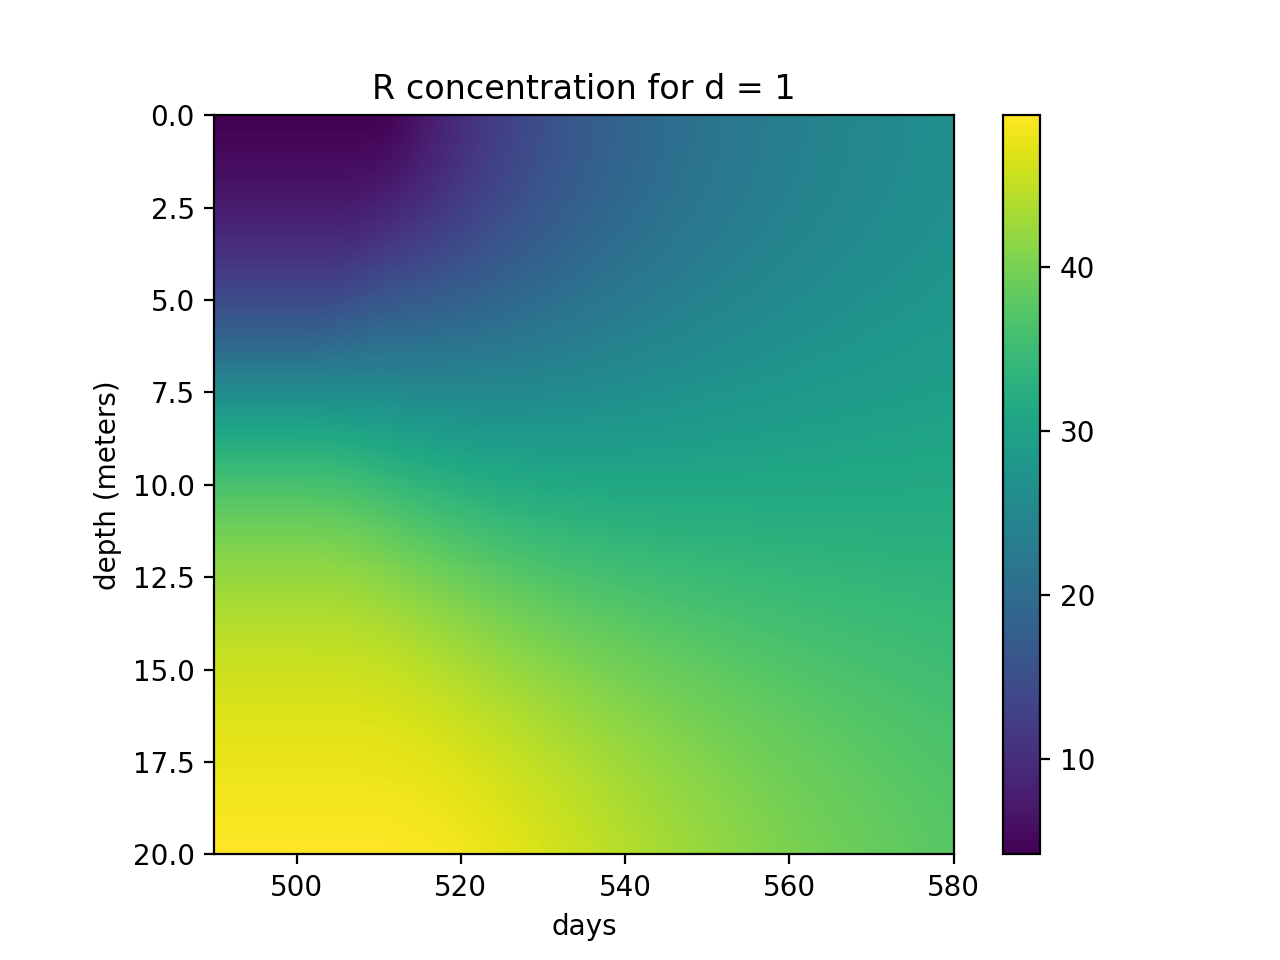

In [48]:
start = 490
end = 580
plt.imshow(R[:,int(start/dz):int(end/dz)],aspect=(end-start)/zmax,origin="lower",extent=(start,end,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("R concentration for d = {}".format(d))
plt.colorbar()

<IPython.core.display.Javascript object>


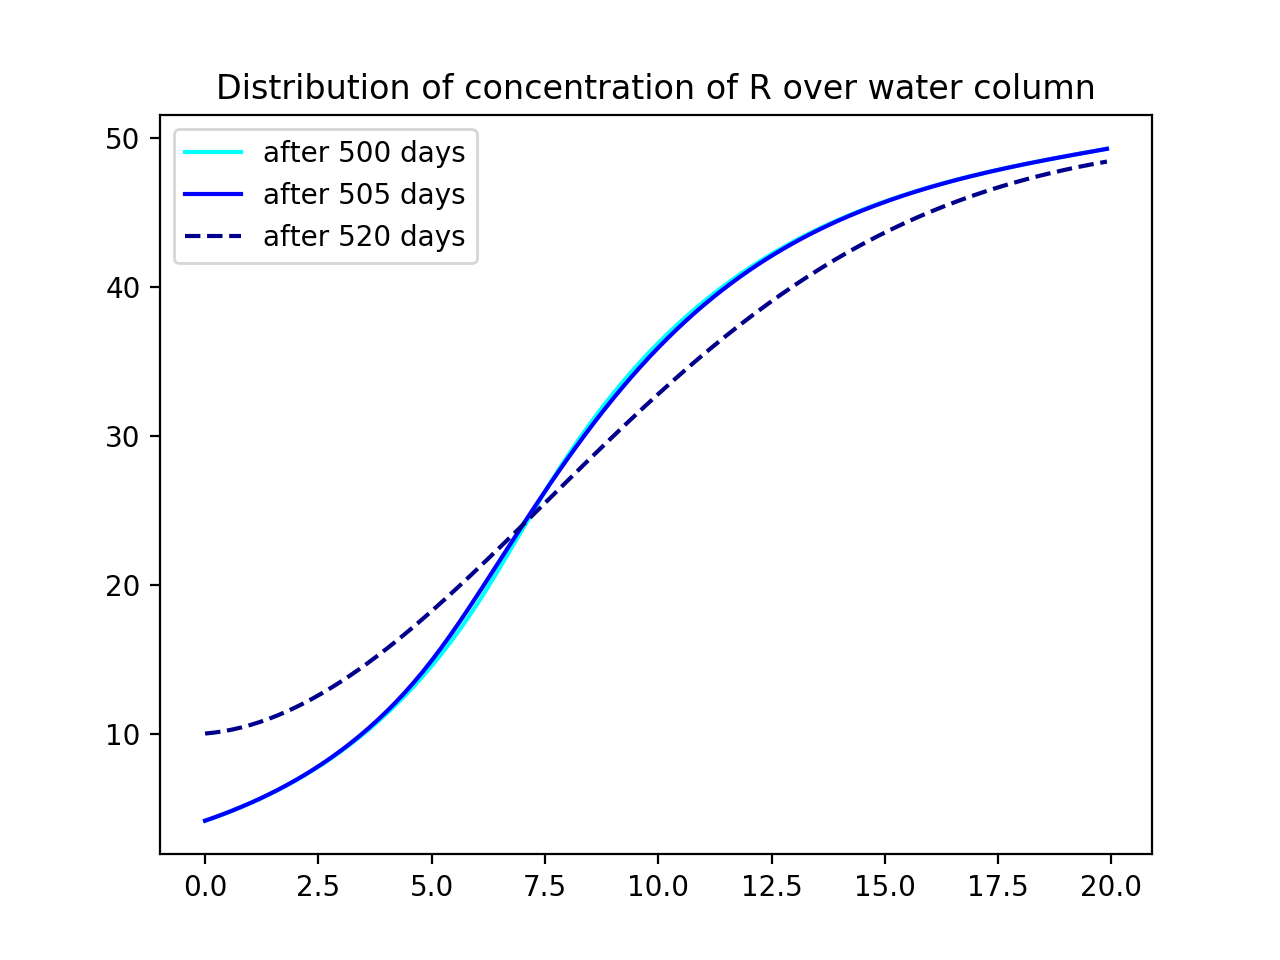

Text(0.5, 1.0, 'Distribution of concentration of R over water column')

In [81]:
# Visualize Shift
first = 500
second = 505
third = 520
plt.plot(z_grid,R[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,R[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,R[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of R over water column')

# Heatmap showing when light returns to system

<IPython.core.display.Javascript object>


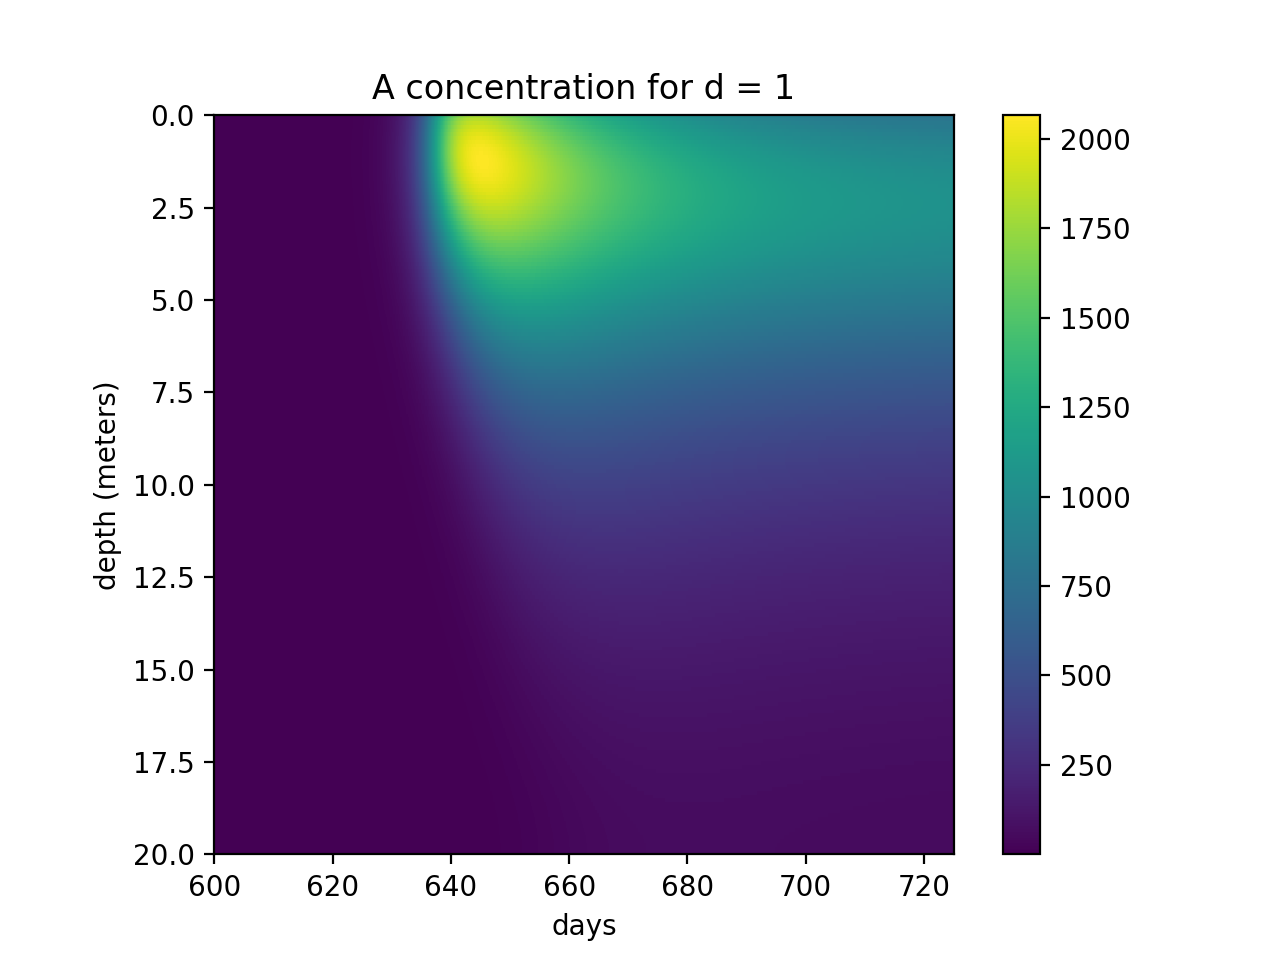

In [51]:
start = 600
end = 725
plt.imshow(A[:,int(start/dz):int(end/dz)],aspect=(end-start)/zmax,origin="lower",extent=(start,end,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("A concentration for d = {}".format(d))
plt.colorbar()

<IPython.core.display.Javascript object>


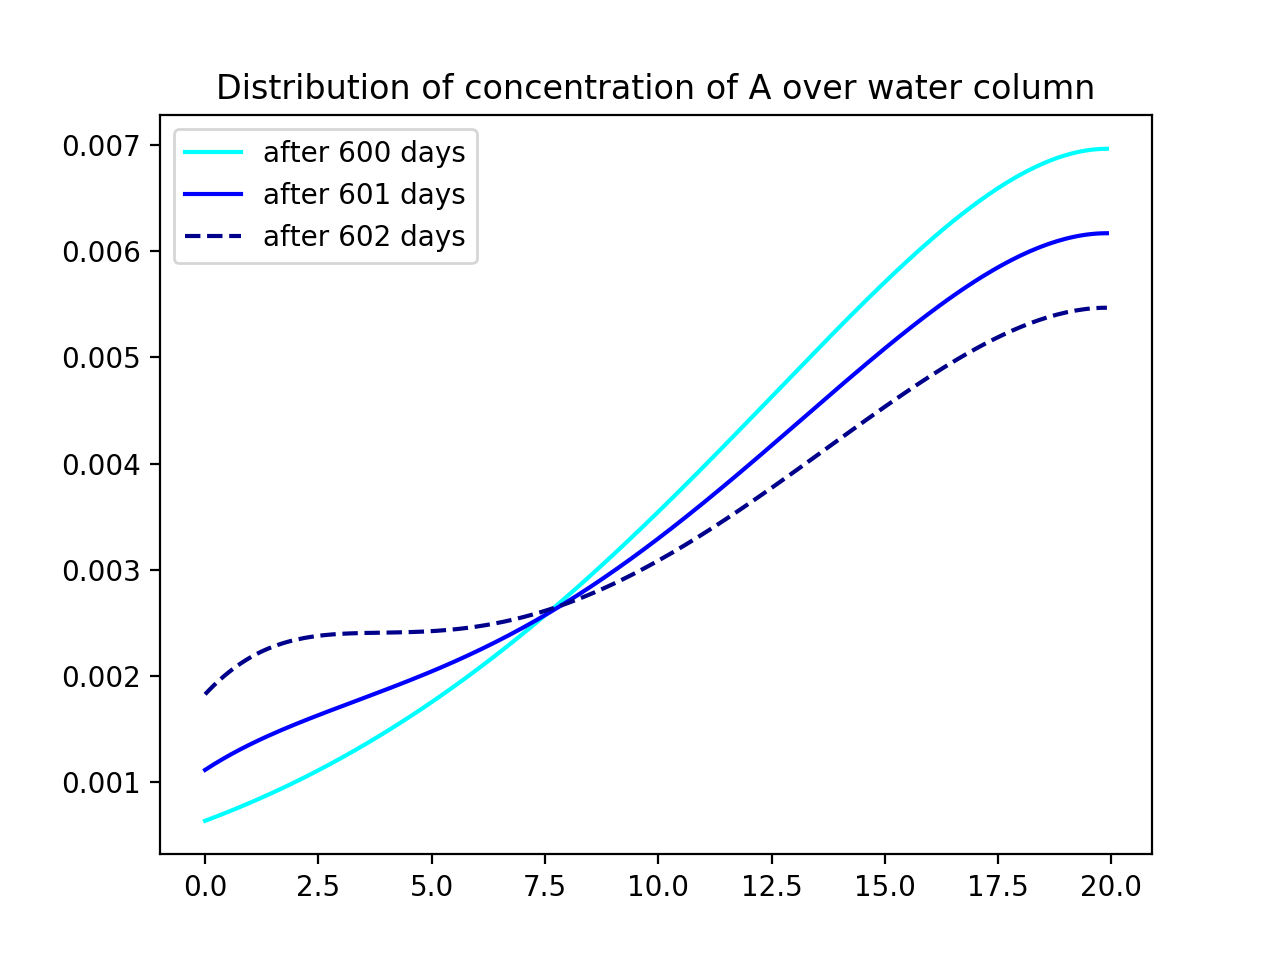

Text(0.5, 1.0, 'Distribution of concentration of A over water column')

In [82]:
# Visualize Shift
first = 600
second = 601
third = 602
plt.plot(z_grid,A[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,A[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,A[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of A over water column')

<IPython.core.display.Javascript object>


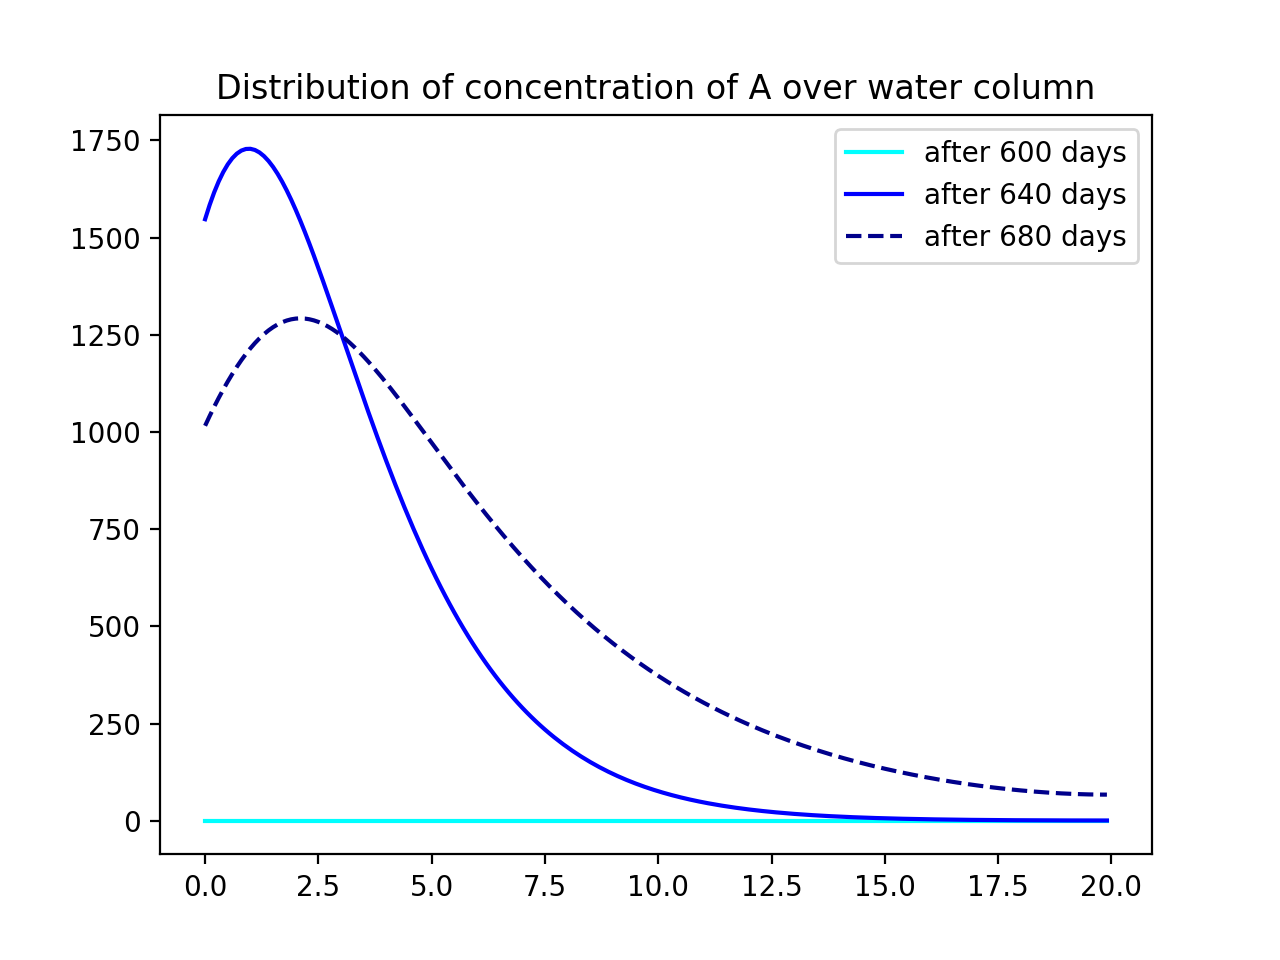

Text(0.5, 1.0, 'Distribution of concentration of A over water column')

In [85]:
# Visualize Shift
first = 600
second = 640
third = 680
plt.plot(z_grid,A[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,A[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,A[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of A over water column')

<IPython.core.display.Javascript object>


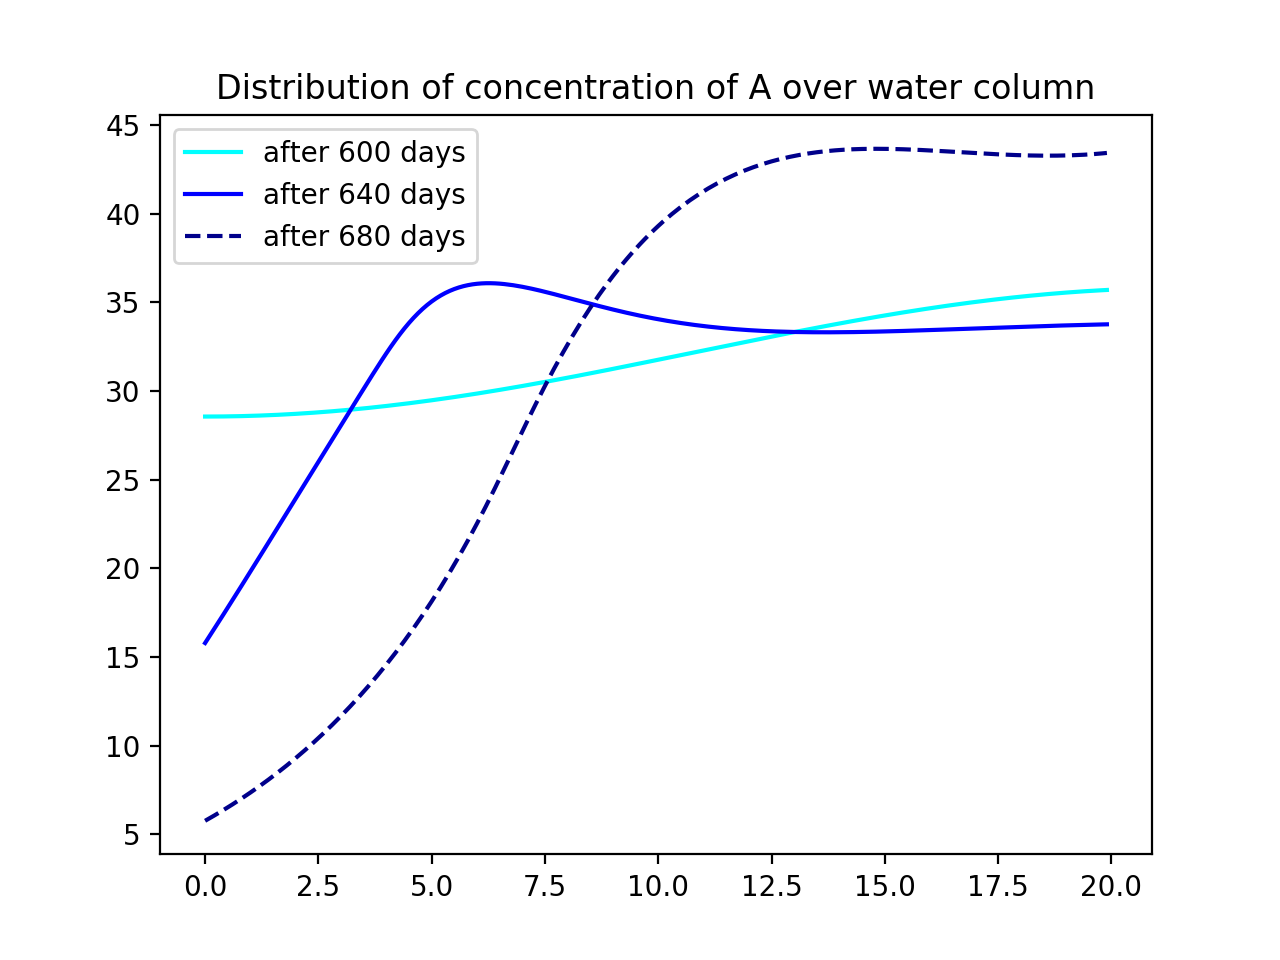

Text(0.5, 1.0, 'Distribution of concentration of A over water column')

In [84]:
# Visualize Shift
first = 600
second = 640
third = 680
plt.plot(z_grid,R[:,int(first/dz)], color = 'aqua')
plt.plot(z_grid,R[:,int(second/dz)],color = 'blue')
plt.plot(z_grid,R[:,int(third/dz)],color = 'darkblue',linestyle='--')
plt.legend('best',labels=('after {} days'.format(first),'after {} days'.format(second),'after {} days'.format(third)))
plt.title('Distribution of concentration of A over water column')

<IPython.core.display.Javascript object>


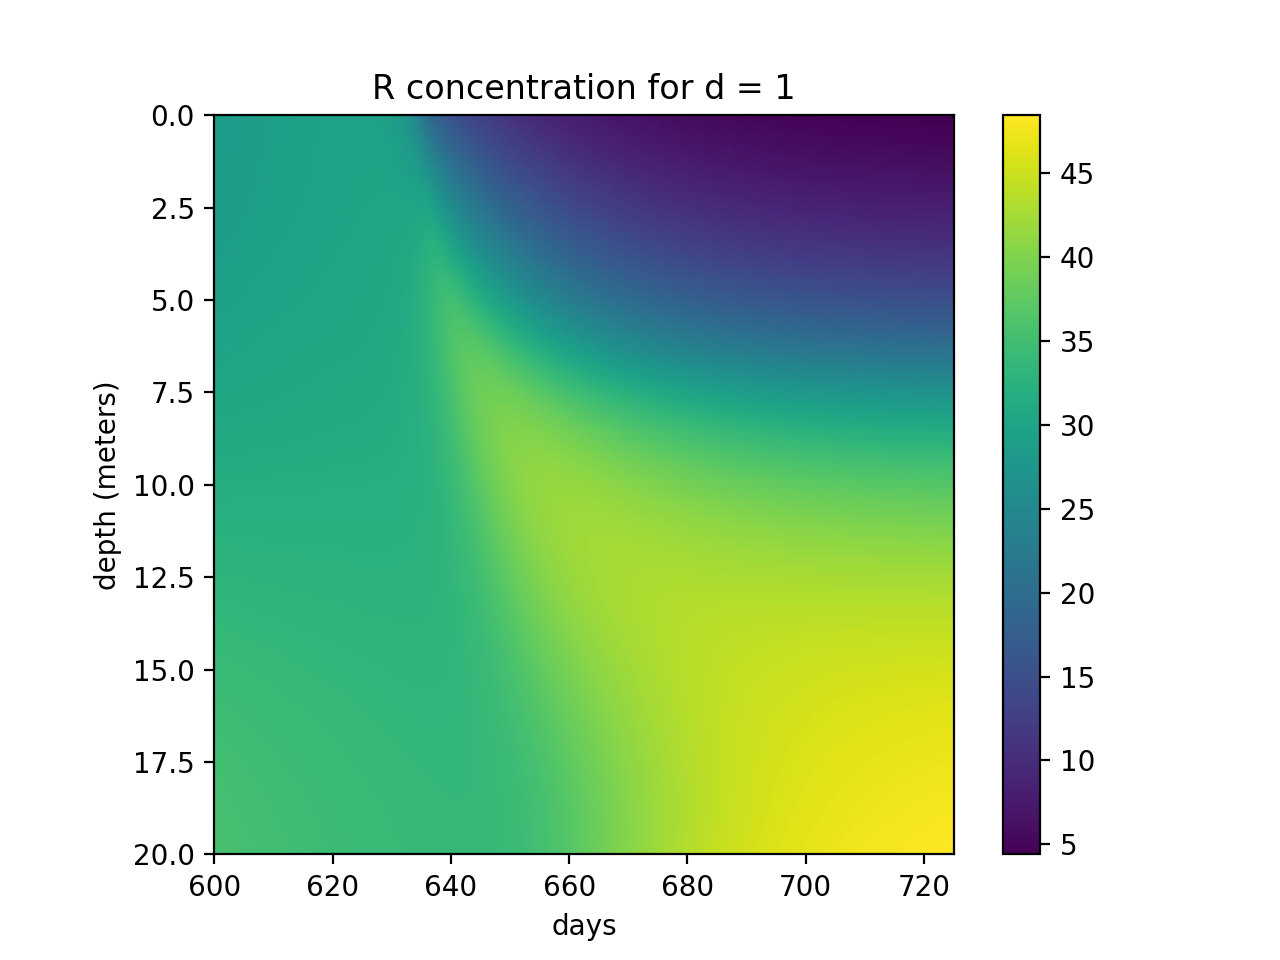

In [52]:
start = 600
end = 725
plt.imshow(R[:,int(start/dz):int(end/dz)],aspect=(end-start)/zmax,origin="lower",extent=(start,end,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.title("R concentration for d = {}".format(d))
plt.colorbar()